# Assignment

In [134]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import torch
import torch.nn as nn
import torch.optim as optim

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [135]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [ ]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    print('a',a)
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION
    print('a agent',a_agent)

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


In [ ]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=100000 # In this case, we will use 100000 episodes to create a random agent as the control of this experiment

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

# Create a manual seed for numpy to make results reproducible
rs = RandomState(MT19937(SeedSequence(3504)))

for n in range(N_episodes):
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=rs.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



In [138]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# INITIALISE THE NETWORKS FOR Q-LEARNING AND SARSA
q_learning_network = NeuralNetwork(N_in, N_h, N_a)
sarsa_network = NeuralNetwork(N_in, N_h, N_a)

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save_q_learning = np.zeros([N_episodes, 1])
N_moves_save_q_learning = np.zeros([N_episodes, 1])
R_save_sarsa = np.zeros([N_episodes, 1])
N_moves_save_sarsa = np.zeros([N_episodes, 1])



In [ ]:
# Q-LEARNING ALGORITHM

# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

# Create a manual seed for numpy to make results reproducible
rs = RandomState(MT19937(SeedSequence(3504)))

# Define the optimizer
optimizer = optim.Adam(q_learning_network.parameters(), lr=eta)

# Define the loss function
loss = nn.MSELoss()

# Loop for each episode
for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    # Initialise S
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    # Loop for each step of episode
    while Done==0:                           ## START THE EPISODE
        # Convert the state to a tensor and add a batch dimension
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0)
        
        # Perform forward pass through the q_learning_network to get Q-values
        Q_values = q_learning_network(X_tensor)
        
        # Choose A from S using epsilon-greedy policy
        allowed_indices = np.where(allowed_a == 1)[0]
        if rs.random() < epsilon_f:
            # Choose a random action
            a_agent = np.random.choice(allowed_indices)
        else:
            # Choose the best action
            a_agent = allowed_indices[torch.argmax(Q_values[0, allowed_indices]).item()]
        
        # Take action A, observe R, S_next
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)
        
        # Convert the next state to a tensor and add a batch dimension
        X_next_tensor = torch.tensor(X_next, dtype=torch.float32).unsqueeze(0)
        
        # Update the Q-values
        # Q(S,A) <- Q(S,A) + eta * (R + gamma * max_a Q(S_next, a) - Q(S,A)

        # Compute the target Q-values
        if Done == 1:
            target_Q_values = Q_values.clone()
            target_Q_values[0, a_agent] = R
        else:
            Q_next = q_learning_network(X_next_tensor)
            target_Q_values = Q_values.clone()
            target_Q_values[0, a_agent] = R + gamma * torch.max(Q_next)
        
        # Compute the loss
        loss = nn.MSELoss()(Q_values, target_Q_values)
        
        # Perform backpropagation and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the current state and action
        # S <- S_next
        S = np.copy(S_next)
        X = np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)
        
        i += 1

    # Update saving variables
    R_save_q_learning[n] = R
    N_moves_save_q_learning[n] = i

print('\nTrained Agent, Average reward:',np.mean(R_save_q_learning),'Number of steps: ',np.mean(N_moves_save_q_learning))
print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))
    

In [ ]:
# SARSA ALGORITHM

# Create a manual seed for numpy to make results reproducible
rs = RandomState(MT19937(SeedSequence(3504)))

# Define the sarsa_optimiser
sarsa_optimiser = optim.Adam(sarsa_network.parameters(), lr=eta)

# Define the loss function
sarsa_loss = nn.MSELoss()

# Loop for each episode
for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)  # Decaying epsilon
    Done = 0  # Set Done to zero (beginning of the episode)
    i = 1  # Counter for number of actions

    # Initialize S
    S, X, allowed_a = env.Initialise_game()  # Initialize game

    # Convert the state to a tensor and add a batch dimension
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0)
    
    # Perform forward pass through the sarsa_network to get Q-values
    Q_values = sarsa_network(X_tensor)

    # Choose A from S using epsilon-greedy policy
    allowed_indices = np.where(allowed_a == 1)[0]
    if rs.random() < epsilon_f:
        # Choose a random action
        a_agent = np.random.choice(allowed_indices)
    else:
        # Choose the best action
        a_agent = allowed_indices[torch.argmax(Q_values[0, allowed_indices]).item()]
    
    # Loop for each step of episode
    while Done == 0:  # Start the episode

        # Take action A, observe R, S_next
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)  # Take action and observe next state
        
        if Done == 1:  # The episode has ended
            # Save reward and number of moves
            R_save_sarsa[n] = R
            N_moves_save_sarsa[n] = i
            break

        # Convert the next state to a tensor and add a batch dimension
        X_next_tensor = torch.tensor(X_next, dtype=torch.float32).unsqueeze(0)

        Q_next_values = sarsa_network(X_next_tensor)  # Pass through the linear layer

        # Choose A_next from S_next using policy derived from Q (e.g., epsilon-greedy)
        allowed_indices_next = np.where(allowed_a_next == 1)[0]
        if np.random.random() < epsilon_f:
            # Random action
            a_next_agent = np.random.choice(allowed_indices_next)
        else:
            # Choose action with the highest Q-value for the next state
            a_next_agent = allowed_indices_next[torch.argmax(Q_next_values[0, allowed_indices_next]).item()]

        # Update Q-value for the current state-action pair using SARSA update rule
        # Q(S,A) <- Q(S,A) + eta * (R + gamma * Q(S_next,A_next) - Q(S,A))
        
        # Compute the target Q-value
        Q_current = Q_values.detach().clone()
        Q_target = Q_values.detach().clone()
        Q_target[0, a_agent] = R + gamma * Q_next_values[0, a_next_agent]

        # Compute the loss
        loss = sarsa_loss(Q_current, Q_target)

        # Perform backpropagation
        sarsa_optimiser.zero_grad()  # Clear the gradients
        loss.backward()  # Compute the gradients
        sarsa_optimiser.step()  # Update the weights

        # Update variables for the next iteration
        # S <- S_next; A <- A_next;
        S = np.copy(S_next)
        X = np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)
        X_tensor = X_next_tensor
        a_agent = a_next_agent

        i += 1  # Update counter for number of actions

print('\nTrained Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa))
print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))

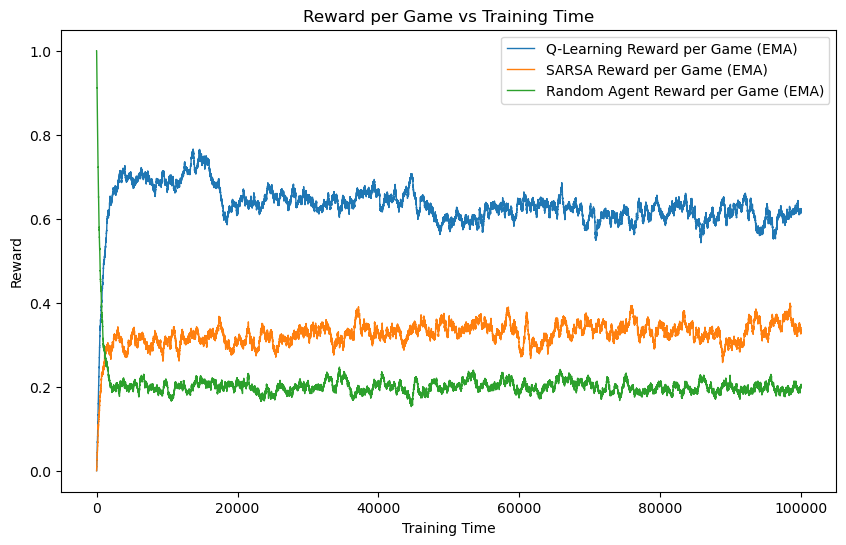

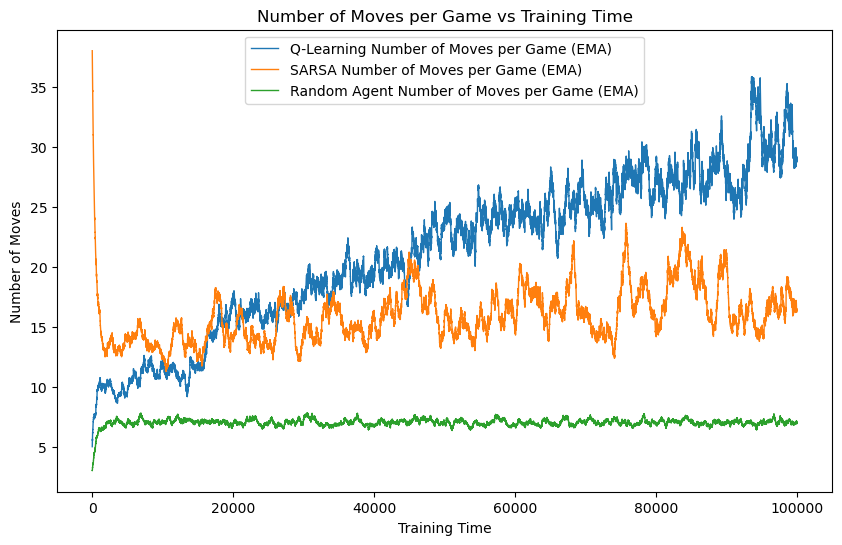

In [150]:
# PLOT THE RESULTS 
# Produce two plots that show the reward per game and the number of moves per
# game vs training time. The plots will be noisy. Use an exponential moving average.

import matplotlib.pyplot as plt

def exponential_moving_average(data, alpha):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[i-1])
    return ema

alpha = 2 / (1000 + 1)  # For exponential moving average, we use a window size of 1000 (1% of the training time)

# Plotting reward per game
reward_ema_q_learning = exponential_moving_average(R_save_q_learning, alpha)
reward_ema_sarsa = exponential_moving_average(R_save_sarsa, alpha)
reward_ema_random = exponential_moving_average(R_save_random, alpha)

plt.figure(figsize=(10, 6))
plt.plot(reward_ema_q_learning, label='Q-Learning Reward per Game (EMA)', linewidth=1)
plt.plot(reward_ema_sarsa, label='SARSA Reward per Game (EMA)', linewidth=1)
plt.plot(reward_ema_random, label='Random Agent Reward per Game (EMA)', linewidth=1)
plt.xlabel('Training Time')
plt.ylabel('Reward')
plt.title('Reward per Game vs Training Time')
plt.legend()
plt.show()

# Plotting number of moves per game
moves_ema_q_learning = exponential_moving_average(N_moves_save_q_learning, alpha=alpha)
moves_ema_sarsa = exponential_moving_average(N_moves_save_sarsa, alpha=alpha)
moves_ema_random = exponential_moving_average(N_moves_save_random, alpha=alpha)

plt.figure(figsize=(10, 6))
plt.plot(moves_ema_q_learning, label='Q-Learning Number of Moves per Game (EMA)', linewidth=1)
plt.plot(moves_ema_sarsa, label='SARSA Number of Moves per Game (EMA)', linewidth=1)
plt.plot(moves_ema_random, label='Random Agent Number of Moves per Game (EMA)', linewidth=1)
plt.xlabel('Training Time')
plt.ylabel('Number of Moves')
plt.title('Number of Moves per Game vs Training Time')
plt.legend()
plt.show()


In [149]:
print('Q-Learning Trained Agent, Average reward:',np.mean(R_save_q_learning),'Number of steps: ',np.mean(N_moves_save_q_learning))
print('SARSA Trained Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa))
print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))

Q-Learning Trained Agent, Average reward: 0.63483 Number of steps:  21.25862
SARSA Trained Agent, Average reward: 0.32674 Number of steps:  15.85614
Random_Agent, Average reward: 0.19918 Number of steps:  7.0303
